# Power analysis for conversion

**Hypothesis**: raising (lowering) the recommended booked budget will lower (raise) conversion.

If this is true, we can change the default recommendation to maximise revenue

```math
\textup{Revenue}(\textup{budget recommendation}) = \textup{conversion}(\textup{budget recommendation}) \times \textup{budget recommendation}
```

And we can choose the recommendation that maximises $\textup{DH Revenue}$. This is not our long term goal, which is vendor value. But learning how to measure response to our policies will be necessary to optimise for the more complicated problem of vendor value.

We want to estimate the $\textup{conversion}$ mapping from budget recommendation size to conversion. 

We can do this by randomly varying the budget recommendation and observing conversion rates.

**Findings**

1. For a significant difference in a month long basic A/B test, we could detect 10% relative uplift using about 1/3 vendors.
2. Our key parameter is the _elasticity_, and we want to test that this is signficantly different from one.

*Note*
- We can also do this for retention and vendor outcomes. These are both likely to be harder to measure, because they are noisier. First, retention and vendor outcomes are both conditional on self service bookings. The self service booking rate is low, [around 1.5% over 2025](https://tableau.deliveryhero.net/#/site/GlobalStandardReporting/views/SelfBookingAnalytics/MBRproduct?=null&:iid=1).

In [5]:
from typing import Dict
import warnings

import matplotlib.pyplot as plt
import numpy as np
from numpy.random._generator import Generator
import pandas as pd
from scipy.stats import bootstrap, norm
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import statsmodels.formula.api as smf
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize

warnings.filterwarnings('ignore')

rng = np.random.default_rng(1312)

- Based on the [Self Booking dashboard](https://tableau.deliveryhero.net/#/site/GlobalStandardReporting/views/SelfBookingAnalytics/MBRproduct?=null&:iid=1), we have a Vendor Portal Conversion Rate around 1.5%.
- We use standard power of 0.8 and type two error rate bound of 0.05
- We have around 650k users per month


# Let's simulate some data and recover parameters



## We want to estimate the elasticity

$$
\epsilon_c = \frac{\% \Delta \textup{Conversions}}{\% \Delta \textup{Recommended Budget}}
$$

where
$$
\% \Delta \textup{Conversions} = \frac{\textup{Conversions with higher budget - Conversions with same budget}}{
    \textup{Conversions with same budget}} \\ 
    \\
    = \frac{\mathbf{E}[\textup{Conversions} | \textup{higher budget}] - \mathbf{E}[\textup{Conversions} | \textup{same budget}]}{
        \mathbf{E}[\textup{Conversions} | \textup{same budget}]}
$$

and the the percentage change in Recommended Budget is what we set in our experiment.

## How we estimate the elasticity

The percentage change we know, we set e.g. 10% higher prices.

For the percentage change in conversions, we can use plug in estimators of the mean

$$
\hat{\%\Delta\textup{Conversions}} =\frac{\frac{1}{n_h}\sum_{i=1}^{n_h} \textup{Conversion}_{h,i} - \frac{1}{n_s}\sum_{i=1}^{n_s} \textup{Conversion}_{s,i}}{\frac{1}{n_s}\sum_{i=1}^{n_s} \textup{Conversion}_{s,i}}
$$

where $h$ and $s$ indicate the users in experimental variants with $higher$ and the $same$ budget respectively. This is the relative change in Eppo!

So our elasticity estimate is

$$
\hat{\epsilon_c} = \frac{\hat{\%\Delta\textup{Conversions}}}{\textup{Change in budget}}
$$

For standard errors, here we use the bootstrap. But in practice, we'll just need to augment Eppo's standard errors, because we are dividing by a constant. Let $Y$ be the relative change in conversions

$$ 
\textup{var}(\hat{\epsilon_c}) = \textup{Var}(\frac{\%\Delta \textup{Conversions}}{\textup{Change in budget}})\\
= \frac{1}{\textup{Change in budget}^2}\textup{Var}(\%\Delta \textup{Conversions})
$$

We can pull out the variance from Eppo and divide it by the change in budget squared. For standard errors, we divide this by the change in budget. For a budget change of 10%, we increase standard errors by a factor of 10.


In [ ]:
def get_variant_conversions(sample_size: int, 
                            conversion_rate: float, 
                            rng_: Generator = rng) -> np.ndarray[int]:
    return rng_.binomial(1, conversion_rate, sample_size)

def get_pc_delta_conversions(conversions_treatment: np.ndarray,
                             conversions_control: np.ndarray) -> float:
    """
        Calculates the percentage change in conversions between treatment and control variants
    """
    mean_treatment = np.mean(conversions_treatment)
    mean_control = np.mean(conversions_control)
    return (mean_treatment - mean_control) / mean_control 

def get_elasticity_estimate(conversions_treatment: np.ndarray,
                            conversions_control: np.ndarray,
                            budget_change: float) -> float:
    """
        Calculates the elasticity given outcomes and treatment effect size
    """
    numerator = get_pc_delta_conversions(conversions_treatment, conversions_control)
    denominator = budget_change
    return numerator / denominator

In [ ]:

def delta_se(treatment, control, pc_change=None):
    """
    Calculate standard error of relative change (treatment - control) / control with Delta Method
    for binary conversion vectors using delta method. Optionally calculate elasticity.
    
    Parameters:
    treatment: array-like of 0s and 1s (treatment group conversions)
    control: array-like of 0s and 1s (control group conversions)
    pc_change: float in (0, 1), percentage change in budget/price (e.g., 0.1 for 10% increase)
    
    Returns:
    dict with relative_change, standard_error, elasticity (if pc_change provided), and intermediate values
    """
    treatment = np.array(treatment)
    control = np.array(control)
    
    # Sample sizes
    n_t = len(treatment)
    n_c = len(control)
    
    # Sample proportions
    p_t = np.mean(treatment)
    p_c = np.mean(control)
    
    # Relative change estimate
    relative_change = (p_t - p_c) / p_c
    
    # Delta method variance calculation
    # Var(θ) = (1/n_c) * [p_t(1-p_t)/p_c^2] + (1/n_c) * [(1-p_c)(p_t-p_c)^2/p_c^3]
    # when n_t = n_c = n, otherwise use separate terms
    
    var_term1 = p_t * (1 - p_t) / (n_t * p_c**2)
    var_term2 = p_t**2 * (1 - p_c) / (n_c * p_c**3)
    
    variance = var_term1 + var_term2
    standard_error = np.sqrt(variance)
    # Elasticity = (% change in conversions) / (% change in budget/price)
    elasticity = relative_change / pc_change 
    # Elasticity variance scales by 1/pc_change^2
    # se scales by 1/pc_change
    elasticity_se = standard_error / pc_change
    
    CI_low = elasticity - 1.96*elasticity_se
    CI_high = elasticity + 1.96*elasticity_se
        
    return {
            'pc_change': pc_change,
            'elasticity': elasticity,
            'elasticity_se': elasticity_se,
            'ci_low': CI_low,
            'ci_high': CI_high
    }

### A single example

Let's compare the confidence interval widths for both Delta Method and Bootstrap estimators

In [ ]:
samples_per_variant = 10000
baseline_cr = 0.015
elasticity = -1
budget_change = 0.1
relative_treatment_effect = elasticity * budget_change
treatment_cr = baseline_cr * (1 + relative_treatment_effect)

elasticity_calc_wrapper = lambda x, y, bc=budget_change: get_elasticity_estimate(x, y, budget_change=bc)

e_estimates = []
ci_width_estimates = []
dm_contains_truth = []
bootstrap_estimates = []
bs_ci_width_estimates = []
bs_contains_truth = []

for i in range(1000):

    control_conversions = get_variant_conversions(samples_per_variant, baseline_cr, rng)
    treatment_conversions = get_variant_conversions(samples_per_variant, treatment_cr, rng)

    delta_method = delta_se(treatment_conversions, control_conversions, budget_change)

    e_estimates.append(delta_method['elasticity'])
    ci_width_estimates.append(delta_method['ci_high'] - delta_method['ci_low'])

    if abs(delta_method['elasticity'] - relative_treatment_effect) < (delta_method['ci_high'] - delta_method['ci_low']) / 2:
        dm_contains_truth.append(True)
    else:
        dm_contains_truth.append(False)
    
    data_tuple = (treatment_conversions, control_conversions)

    bs_result = bootstrap(
        data=data_tuple,
        statistic=elasticity_calc_wrapper,
        n_resamples=1000,
        method='BCa',
        random_state=rng
    )
    bs_ci = bs_result.confidence_interval
    bs_ci_width = bs_ci.high - bs_ci.low
    point_estimate = get_pc_delta_conversions(treatment_conversions, control_conversions) / budget_change

    bootstrap_estimates.append(point_estimate)
    bs_ci_width_estimates.append(bs_ci_width)

    if abs(point_estimate - relative_treatment_effect) < (bs_ci_width) / 2:
        bs_contains_truth.append(True)
    else:
        bs_contains_truth.append(False)

print("=" * 50)
print("\t\t Delta Method")
print("=" * 50)
print(f"The average estimate is {np.mean(e_estimates):.3f}")
print(f"The average CI width is {np.mean(ci_width_estimates):.3f}")
print(f"The CI contains the truth {100*np.mean(dm_contains_truth):.3f}% of the time")

print("=" * 50)
print("\t\t Bootstrap estimates")
print("=" * 50)
print(f"The average estimate is {np.mean(bootstrap_estimates):.3f}")
print(f"The average CI width is {np.mean(bs_ci_width_estimates):.3f}")
print(f"The CI contains the truth {100*np.mean(bs_contains_truth):.3f}% of the time")

print("\n")
print(f"The true elasticity is {elasticity}")

		 Delta Method
The average estimate is -0.989
The average CI width is 1.160
The CI contains the truth 40.000% of the time
		 Bootstrap estimates
The average estimate is -0.989
The average CI width is 1.039
The CI contains the truth 40.000% of the time


The true elasticity is -1


In [52]:
samples_per_variant = 5000
baseline_cr = 0.015
elasticity = -1
budget_change = 0.10

delta_method_mean = []
delta_method_ci_width = []
delta_coverage = []
bootstrap_mean = []
bootstrap_ci_width = []
bootstrap_coverage = []

baseline_conversion_rate_list = [0.01, 0.02] # 0.05, 0.1, 0.2, 0.35, 0.5]

for baseline_cr in baseline_conversion_rate_list:
    treatment_effect = elasticity * budget_change
    treatment_cr = baseline_cr * (1 + treatment_effect)
    
    e_estimates = []
    ci_width_estimates = []
    dm_contains_truth = []
    bootstrap_estimates = []
    bs_ci_width_estimates = []
    bs_contains_truth = []


    for i in range(10):

        control_conversions = get_variant_conversions(samples_per_variant, baseline_cr, rng)
        treatment_conversions = get_variant_conversions(samples_per_variant, treatment_cr, rng)

        delta_method = delta_se(treatment_conversions, control_conversions, budget_change)

        e_estimates.append(delta_method['elasticity'])
        ci_width_estimates.append(delta_method['ci_high'] - delta_method['ci_low'])

        if abs(delta_method['elasticity'] - relative_treatment_effect) < (delta_method['ci_high'] - delta_method['ci_low']) / 2:
            dm_contains_truth.append(True)
        else:
            dm_contains_truth.append(False)
        
        data_tuple = (treatment_conversions, control_conversions)

        bs_result = bootstrap(
            data=data_tuple,
            statistic=elasticity_calc_wrapper,
            n_resamples=10,
            method='BCa',
            random_state=rng
        )
        bs_ci = bs_result.confidence_interval
        bs_ci_width = bs_ci.high - bs_ci.low
        point_estimate = get_pc_delta_conversions(treatment_conversions, control_conversions) / budget_change

        bootstrap_estimates.append(point_estimate)
        bs_ci_width_estimates.append(bs_ci_width)

        if abs(point_estimate - relative_treatment_effect) < (bs_ci_width) / 2:
            bs_contains_truth.append(True)
        else:
            bs_contains_truth.append(False)

    delta_method_mean.append(np.mean(e_estimates))
    delta_method_ci_width.append(np.mean(ci_width_estimates))
    delta_coverage.append(np.mean(dm_contains_truth))
    bootstrap_mean.append(np.mean(bootstrap_estimates))
    bootstrap_ci_width.append(np.mean(bs_ci_width_estimates))
    bootstrap_coverage.append(np.mean(bs_contains_truth))


df_bs_dm = pd.DataFrame(
    {'cr': baseline_conversion_rate_list,
     'dm_mean': delta_method_mean,
     'dm_ci_w': delta_method_ci_width,
     'dm_calibration': delta_coverage,
     'bs_mean': bootstrap_mean,
     'bs_ci_w': bootstrap_ci_width,
     'bs_calibration': bootstrap_coverage}
)

In [26]:
df_bs_dm

,cr,dm_mean,dm_ci_w,bs_mean,bs_ci_w
0,0.01,-0.192559,5.821757,-0.582468,0.331499
1,0.02,-0.013716,4.013122,-0.573526,0.238959
2,0.05,-0.887781,2.351314,-0.617229,0.182010
3,0.10,-1.042157,1.595560,-0.624948,0.145654
4,0.20,-1.063908,1.066075,-0.626035,0.124434
5,0.35,-0.936704,0.741051,-0.619675,0.102191
6,0.50,-1.019602,0.554521,-0.623820,0.091476


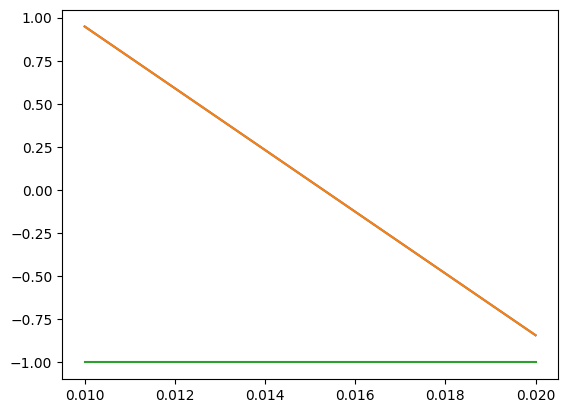

In [53]:
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.dm_mean,
    label='Delta Method'
)
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.bs_mean,
    label='Bootstrap'
)
plt.plot(
    df_bs_dm.cr,
    [-1] * len(df_bs_dm.cr),
    label='Elasticity'
)

Eppo uses the [Delta Method](https://docs.geteppo.com/statistics/confidence-intervals/statistical-nitty-gritty/#frequentist-analysis)

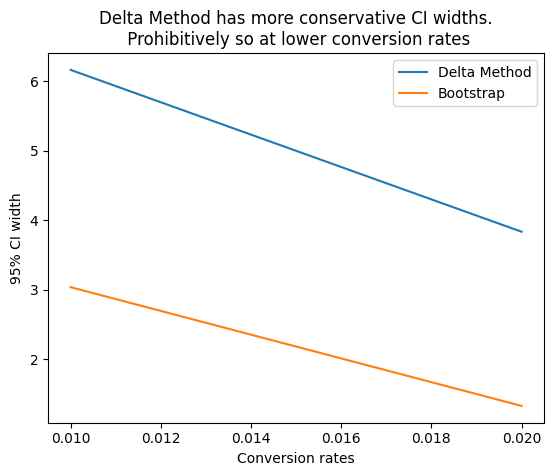

In [54]:
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.dm_ci_w,
    label='Delta Method'
)
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.bs_ci_w,
    label='Bootstrap'
)
plt.title("Delta Method has more conservative CI widths.\n Prohibitively so at lower conversion rates")
plt.xlabel("Conversion rates")
plt.ylabel("95% CI width")
plt.legend()

In [33]:
experiment_df = df.loc[df.assignment != 'down']
experiment_df['treatment'] = np.where([a == 'up' for a in experiment_df.assignment.values], budget_change, 0)

model = smf.glm(formula='conversion ~ treatment', data=experiment_df, family=sm.families.Binomial()).fit()
model.params['treatment']

np.float64(0.0)

In [30]:
experiment_df['prediction'] = model.predict()
pred_treatment = experiment_df.loc[experiment_df.treatment != 0].prediction
pred_control = experiment_df.loc[experiment_df.treatment == 0].prediction
np.log(np.mean(pred_treatment)) - np.log(np.mean(pred_control)) / np.log(budget_change * 100)

np.float64(nan)

Fit a model outcome ~ treat + covariates (clustered), then compute predicted probabilities for each arm p̂_t, p̂_c. Then elasticity:
elasticity = [log(p̂_t) - log(p̂_c)] / log(P_t / P_c)

Get CIs by cluster bootstrap (resample clusters with replacement, recompute both predicted probs and elasticity each bootstrap).

In [289]:
model.get_margeff(method='eydx').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
         GLM Marginal Effects        
=====================================
Dep. Variable:             conversion
Method:                          eydx
At:                           overall
==============================================================================
            d(lny)/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment     -1.3717      0.076    -18.077      0.000      -1.520      -1.223
==============================================================================
"""

In [290]:
np.mean(bootstrap_estimates)

np.float64(-1.2000456596239202)

In [291]:
model = smf.ols(formula='conversion ~ treatment', data=experiment_df).fit()
model.params['treatment']

np.float64(-0.6469664415556765)

In [236]:
get_pc_delta_conversions(outcomes['treatment'], outcomes['control'])

np.float64(-0.22586323446291584)

In [301]:
outcomes['treatment'].mean() - outcomes['control'].mean()

np.float64(-0.15434522302518244)

In [300]:
np.mean(bootstrap_estimates)

np.float64(-1.3818264758651992)

First we use a Wald Estimator

$$
\theta = \frac{E[\ln(\textup{Conversion}) | \textup{Higher budget}] - E[\ln(\textup{Conversion}) | \textup{Lower budget}]}
{E[\ln(\textup{Budget}) | \textup{Higher Budget}] - E[\ln\textup{Budget} | \textup{Lower Budget}]}
$$

Note, this is a linear estimator, but our model is non linear. So there will be some approximation error.

In [8]:
def get_wald_estimate_simple(df: pd.DataFrame, Z1_name: str, Z0_name: str) -> float:
    # Delta log conversion rate / Delta log budget
    p1 = df.loc[df['assignment']==Z1_name]['conversion'].mean()
    p0 = df.loc[df['assignment']==Z0_name]['conversion'].mean()
    
    delta_ln_conversion = np.log(p1) - np.log(p0)
    delta_ln_budget = np.mean(np.log(df.loc[df.assignment==Z1_name].budget)) - \
                      np.mean(np.log(df.loc[df.assignment==Z0_name].budget))
    
    return delta_ln_conversion / delta_ln_budget


Z1 = ['up', 'same', 'up']
Z0 = ['same', 'down', 'down']
for z1, z0 in zip(Z1, Z0):
    wald_bs = [get_wald_estimate_simple(df.sample(n=10000, replace=True), z1, z0) for i in range(1000)]
    print(f"Estimated elasticity ({z1} to {z0}) is {np.mean(wald_bs):.2f}, ({np.quantile(wald_bs, 0.05):.2f}, {np.quantile(wald_bs, 0.95):.2f})")

Estimated elasticity (up to same) is -1.06, (-2.76, 0.71)
Estimated elasticity (same to down) is -3.65, (-4.74, -2.59)
Estimated elasticity (up to down) is -2.44, (-3.20, -1.77)


In [9]:
def simple_iv_logit(df):
    df['log_budget'] = np.log(df['budget'])
    
    # Create instrument dummies
    df['up_dummy'] = (df['assignment'] == 'up').astype(int)
    df['down_dummy'] = (df['assignment'] == 'down').astype(int)
    
    # First stage: log_budget ~ up_dummy + down_dummy
    X_first = sm.add_constant(df[['up_dummy', 'down_dummy']])
    first_stage = sm.OLS(df['log_budget'], X_first).fit()
    df['residual_v1'] = first_stage.resid
    
    # Second stage logit
    X_second = sm.add_constant(df[['log_budget', 'residual_v1']])
    logit_model = Logit(df['conversion'], X_second).fit(disp=False)
    
    elasticity = logit_model.params['log_budget']
    ci_elasticity = logit_model.conf_int(alpha=0.05).loc['log_budget'].values
    return elasticity, logit_model, ci_elasticity

# Usage
print(f"Elasticity: {elasticity}")
est_elasticity, model, ci = simple_iv_logit(df.sample(n=1000, replace=True))
print(f"IV Logit elasticity: {est_elasticity:.3f}, ({model.conf_int(alpha=0.05).loc['log_budget'].values})")
print(f"Test of exogeneity (residual coef): {model.params['residual_v1']:.3f}")
print(f"P-value: {model.pvalues['residual_v1']:.3f}")

iv_ests = [(e, True if m.pvalues['residual_v1']> 0.05 else False) for e, m, ci in [simple_iv_logit(df.sample(n=10000, replace=True)) for i in range(100)]]

print(f"Estimated elasticity is {np.mean([x[0] for x in iv_ests]):.2f}, ({np.quantile([x[0] for x in iv_ests], 0.05):.2f}, {np.quantile([x[0] for x in iv_ests], 0.95):.2f})")

Elasticity: -3
IV Logit elasticity: -1.260, ([-3.84802476  1.32739887])
Test of exogeneity (residual coef): -2.339
P-value: 0.365
Estimated elasticity is -2.79, (-3.58, -2.05)


## Exploiting estimates


In [10]:
simulated_results = simulate_outcomes(df, alpha, elasticity, est_elasticity, -0.1) 
simulated_results

{'original': np.float64(985093.6589743372),
 'simulated': np.float64(888244.6510297453)}

By lowering revenue, we can raise revenue

In [11]:
alpha = -4
elasticity = -0.00
df = get_simulation(10000, 0.2, alpha, elasticity)
print(f"Elasticity: {elasticity}")
est_elasticity, model, ci = simple_iv_logit(df)
print(f"IV Logit elasticity: {est_elasticity:.3f}, ({model.conf_int(alpha=0.05).loc['log_budget'].values})")
print(f"Test of exogeneity (residual coef): {model.params['residual_v1']:.3f}")
print(f"P-value: {model.pvalues['residual_v1']:.3f}")

iv_ests = [(e, True if m.pvalues['residual_v1']> 0.05 else False) for e, m, ci in [simple_iv_logit(df.sample(n=10000, replace=True)) for i in range(100)]]

print(f"Estimated elasticity is {np.mean([x[0] for x in iv_ests]):.2f}, ({np.quantile([x[0] for x in iv_ests], 0.05):.2f}, {np.quantile([x[0] for x in iv_ests], 0.95):.2f})")


simulated_results = simulate_outcomes(df, alpha, elasticity, est_elasticity, 0.1) 
simulated_results

Elasticity: -0.0
IV Logit elasticity: 0.569, ([-0.36355157  1.50093122])
Test of exogeneity (residual coef): -0.838
P-value: 0.362
Estimated elasticity is 0.52, (-0.25, 1.33)


{'original': np.float64(201607.62295949477),
 'simulated': np.float64(231517.04710532047)}

In [12]:
alpha = -3
elasticity = -1/10
print(f"True elasticity is {elasticity}")
df = get_simulation(10000, 0.2, alpha, elasticity)
print(f"Baseline conversion rate {df.conversion.mean()}")
if abs(elasticity) < 1:
    print("Raise prices to increase revenue")
else:
    print("Lower prices to increase revenue")

True elasticity is -0.1
Baseline conversion rate 0.0292
Raise prices to increase revenue


In [13]:
gt_params = [
    (20, -5),
    (15, -4),
    (10, -3),
    (5, -2),
    (0, -1),
    (-2, -1/2),
    (-3, -1/10)
]

In [364]:
bs_results = []

n_sims = 100
for alpha, elasticity in gt_params:
    print(f"Elasticity is {elasticity}")
    raise_counter = 0
    lower_counter = 0
    for i in range(n_sims):
        df = get_simulation(10000, 0.2, alpha, elasticity)
        iv_est, model, ci = simple_iv_logit(df)
        # sanity check
        # iv_est = elasticity
        # ci = [elasticity, elasticity] 
        if ci[1] < -1:
            # upper bound of estimate is less than -1
            # elastic, lower prices
            sim_change = -0.1
            lower_counter += 1
        elif ci[0] > -1:
            # lower bound of estimate is greater than -1
            # inelastic, raise prices
            sim_change = 0.1
            raise_counter += 1
        else:
            # inconclusive
            sim_change = 0
        simulated_results = simulate_outcomes(df, alpha, elasticity, iv_est, sim_change) 
        simulated_results['iv_est'] = iv_est
        simulated_results['elasticity'] = elasticity
        simulated_results['budget_change'] = sim_change

        bs_results.append(simulated_results)    

    print(f"Lower prices in {lower_counter / n_sims:.2f} share of simulations")
    print(f"Raise prices in {raise_counter / n_sims:.2f} share of simulations")

df_bootstrap = pd.DataFrame(bs_results)
df_bootstrap['uplift'] = df_bootstrap['simulated'] - df_bootstrap['original']
df_bootstrap.groupby("elasticity")['uplift'].mean()

Elasticity is -5
Lower prices in 1.00 share of simulations
Raise prices in 0.00 share of simulations
Elasticity is -4
Lower prices in 1.00 share of simulations
Raise prices in 0.00 share of simulations
Elasticity is -3
Lower prices in 1.00 share of simulations
Raise prices in 0.00 share of simulations
Elasticity is -2
Lower prices in 0.52 share of simulations
Raise prices in 0.00 share of simulations
Elasticity is -1
Lower prices in 0.02 share of simulations
Raise prices in 0.03 share of simulations
Elasticity is -0.5
Lower prices in 0.00 share of simulations
Raise prices in 0.15 share of simulations
Elasticity is -0.1
Lower prices in 0.00 share of simulations
Raise prices in 0.69 share of simulations


elasticity
-5.0    28089.289308
-4.0    15582.050573
-3.0     6768.329844
-2.0      364.243687
-1.0     2584.977648
-0.5     4597.322005
-0.1     7221.189765
Name: uplift, dtype: float64

We can increase revenue in every case, on expectation.

Concerns

- very hard to get practical estimates for relatively inelastic estimates
- with 20% changes up, down we only get significance for around 1/2 estimates when elasticity in {-2, 1/2}
- For elasticity < -3, we always decrease, correctly
- For elasiticty = -0.1, we only increase 0.7 simulations